## Movie Success Analysis

Goal: Understand what makes a movie successful financially and critically using **The Movies Dataset (Kaggle)**.  
We analyze relationships between **budget, revenue, ROI, profit, genre, ratings, popularity, and time**.

Main questions:
- Does spending more increase revenue?
- Which genres earn more?
- Do higher ratings guarantee better box office?
- How has profitability changed over decades?


In [ ]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 4.5)


## 1. Load the cleaned dataset

We use the cleaned file produced by our pipeline:  
`data/movies_clean.csv`

Important note: after saving to CSV, columns like `genre_names` become strings,  
so we convert them back to Python lists.


In [ ]:
#Load data

df = pd.read_csv("../data/movies_clean.csv")

# Convert stringified lists back to real lists
df["genre_names"] = df["genre_names"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Drop rows missing critical values
df = df.dropna(subset=["budget", "revenue", "roi", "profit", "release_year"])

df.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,profit,roi,release_year,genre_names
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,343554033.0,11.451801,1995,"[Animation, Comedy, Family]"
1,False,[],65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,197797249.0,3.043035,1995,"[Adventure, Fantasy, Family]"
2,False,[],16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,65452156.0,4.090760,1995,"[Comedy, Drama, Romance]"
3,False,[],60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,127436818.0,2.123947,1995,"[Action, Crime, Drama, Thriller]"
4,False,[],35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,29350171.0,0.838576,1995,"[Action, Adventure, Thriller]"


## 2. Quick data overview

We check dataset size and key columns to confirm everything loaded correctly.


In [ ]:
#  Shape and columns

print("Shape:", df.shape)
df[["budget","revenue","profit","roi","vote_average","vote_count","popularity","release_year"]].describe()


Shape: (5307, 28)


,budget,revenue,profit,roi,vote_average,vote_count,popularity,release_year
count,5.307000e+03,5.307000e+03,5.307000e+03,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000
mean,3.148915e+07,9.151499e+07,6.002584e+07,8.070325,6.279235,741.558884,9.866697,1999.812889
std,4.029214e+07,1.669735e+08,1.403264e+08,189.568101,0.913499,1257.650498,13.887469,15.810346
min,2.500000e+03,1.404000e+03,-1.657101e+08,-0.999790,0.000000,0.000000,0.000657,1915.000000
25%,5.900000e+06,7.555745e+06,-1.524972e+06,-0.200266,5.700000,81.000000,5.551433,1994.000000
50%,1.700000e+07,3.050000e+07,1.155514e+07,1.069137,6.300000,283.000000,8.449722,2004.000000
75%,4.000000e+07,1.005980e+08,6.391789e+07,3.239814,6.900000,813.500000,11.787421,2011.000000
max,3.800000e+08,2.787965e+09,2.550965e+09,12889.386667,9.100000,14075.000000,547.488298,2017.000000


## 3. Budget vs Revenue (log–log scale)

Why log–log?
- budgets and revenues span **orders of magnitude**
- log scale prevents large blockbusters from hiding small/medium films
- helps reveal proportional patterns

Interpretation:
- **positive trend** → higher budget usually leads to higher revenue  
- **big variance** → budget is not a guarantee of success


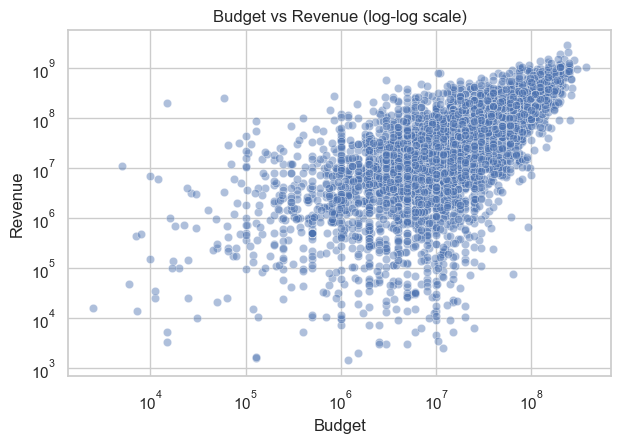

In [ ]:
# Budget vs Revenue

plt.figure()
sns.scatterplot(data=df, x="budget", y="revenue", alpha=0.45)
plt.xscale("log")
plt.yscale("log")
plt.title("Budget vs Revenue (log-log scale)")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()


## 4. ROI Distribution (capped at 95th percentile)

ROI = (revenue − budget) / budget

ROI is extremely skewed because some low-budget films earn huge revenue.  
To keep the histogram readable, we **cap at the 95th percentile**:

- compute 95th percentile ROI value  
- replace any ROI bigger than that value with the cap  
- prevents outliers from stretching the axis

Interpretation:
- most films have small ROI  
- a few films generate very high ROI  
- filmmaking is high financial risk


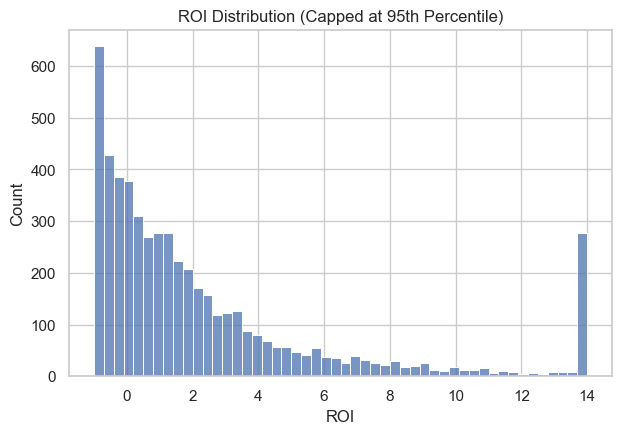

In [ ]:
#  ROI Distribution (capped)

cap = np.percentile(df["roi"], 95)
roi_capped = df["roi"].clip(upper=cap)

plt.figure()
sns.histplot(roi_capped, bins=50)
plt.title("ROI Distribution (Capped at 95th Percentile)")
plt.xlabel("ROI")
plt.ylabel("Count")
plt.show()


## 5. Average Profit per Year

Profit = revenue − budget

We calculate mean profit per release year to see industry evolution.

Interpretation:
- early years unstable due to few films
- long-term upward trend suggests growth of global markets and higher movie scale


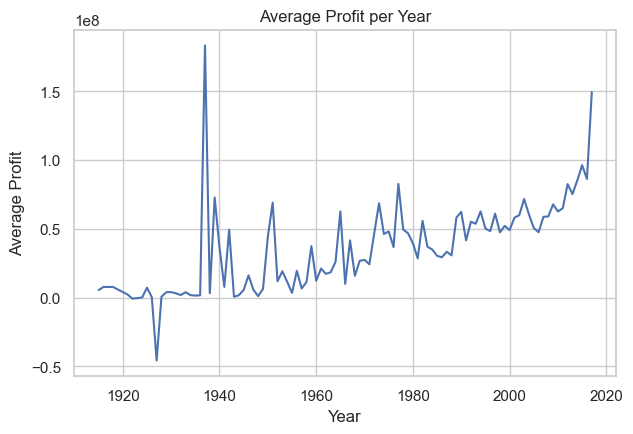

In [ ]:
# Profit per year

profit_year = df.groupby("release_year")["profit"].mean()

plt.figure()
profit_year.plot()
plt.title("Average Profit per Year")
plt.xlabel("Year")
plt.ylabel("Average Profit")
plt.show()


## 6. Top 10 Genres by Average Revenue

Movies can have multiple genres.  
We use:

- `explode()` to create one row per movie-genre
- group by genre
- compute mean revenue

Interpretation:
- event/franchise genres dominate (Animation, Adventure, Fantasy, Sci-Fi, etc.)
- genre choice affects earning potential


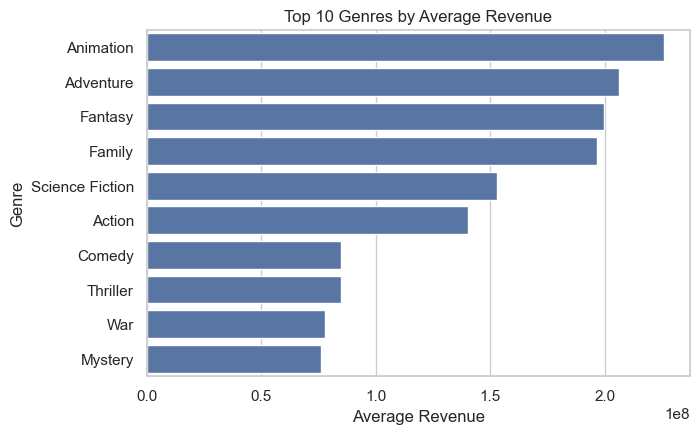

In [ ]:
#  Top genres by revenue

genres_long = df.explode("genre_names")

top_genres = (
    genres_long.groupby("genre_names")["revenue"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
sns.barplot(y=top_genres.index, x=top_genres.values)
plt.title("Top 10 Genres by Average Revenue")
plt.xlabel("Average Revenue")
plt.ylabel("Genre")
plt.show()


## 7. Rating (Vote Average) vs Revenue

We test whether ratings predict financial success.

Interpretation:
- relationship is weak
- high ratings do not guarantee high revenue
- marketing/franchise/budget drive box office more than rating alone


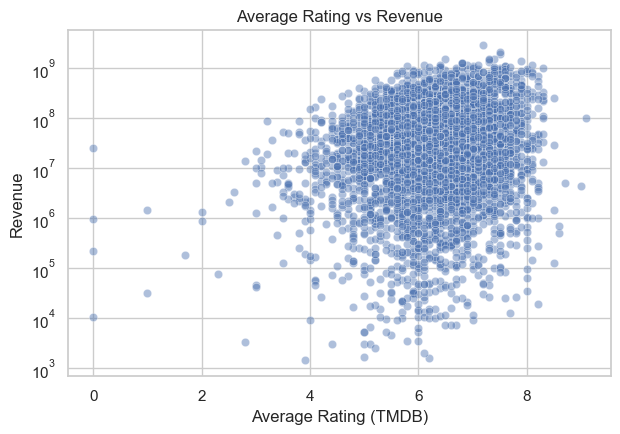

In [ ]:
# Vote average vs revenue

plt.figure()
sns.scatterplot(data=df, x="vote_average", y="revenue", alpha=0.45)
plt.yscale("log")
plt.title("Average Rating vs Revenue")
plt.xlabel("Average Rating (TMDB)")
plt.ylabel("Revenue")
plt.show()


## 8. Correlation Heatmap

Correlation matrix across key numeric variables.

Interpretation:
- budget ↔ revenue strong correlation  
- revenue ↔ profit extremely strong  
- ratings weak correlation with revenue  
- vote_count/popularity moderate correlation with revenue (visibility effect)


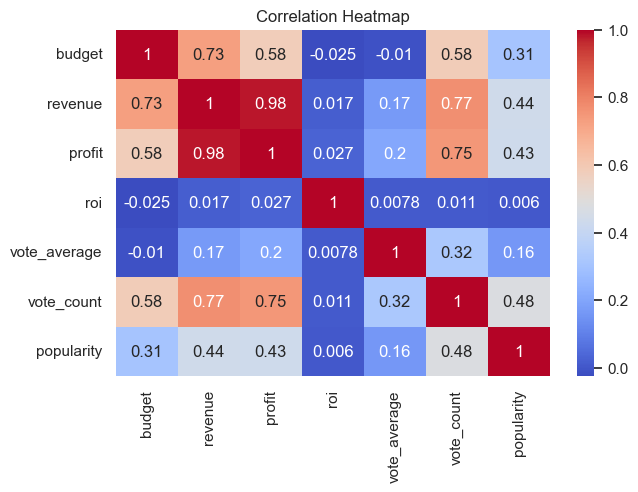

In [ ]:
# Correlation heatmap

subset = df[["budget","revenue","profit","roi","vote_average","vote_count","popularity"]]

plt.figure()
sns.heatmap(subset.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## 9. Top 20 Highest Grossing Movies

Simple ranking by revenue.

Interpretation:
- dominated by franchise/event films
- revenue concentrated in a small set of global blockbusters


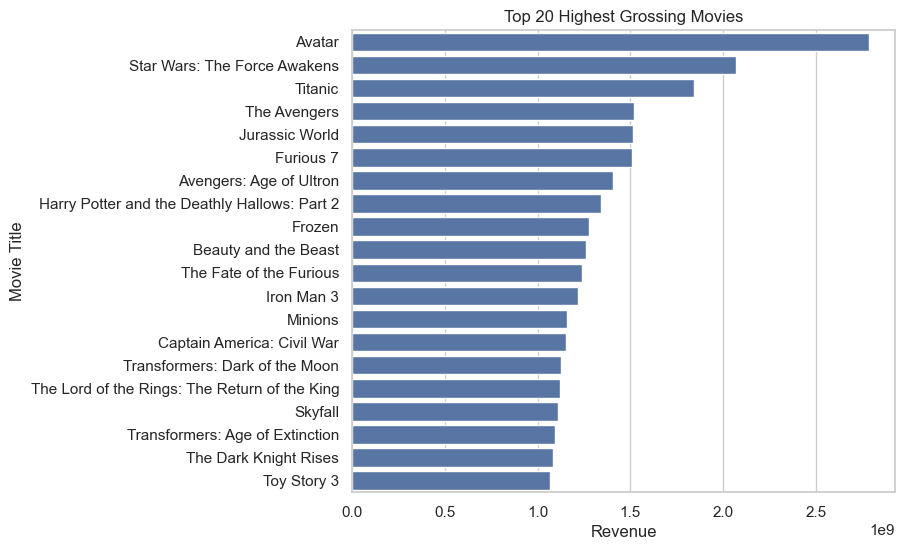

In [ ]:
#  Top 20 by revenue

top20 = df.sort_values("revenue", ascending=False).head(20)

plt.figure(figsize=(7, 6))
sns.barplot(y=top20["title"], x=top20["revenue"])
plt.title("Top 20 Highest Grossing Movies")
plt.xlabel("Revenue")
plt.ylabel("Movie Title")
plt.show()


## Final Summary 

1. **Budget predicts revenue**, but not perfectly. Big spend increases potential, not certainty.  
2. **ROI is highly skewed** — most movies earn small returns, few earn extreme returns.  
3. **Profitability rises over time**, especially after mid-century.  
4. **Genres matter**: blockbuster-friendly genres dominate revenue.  
5. **Ratings are weak predictors of revenue**; visibility and scale matter more.  

Limitations:
- no marketing spend, streaming revenue, or external hype signals  
- missing/incorrect entries in Kaggle dataset  
- ROI outliers need careful handling
